### Import

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle

import keras
from keras.preprocessing.sequence import pad_sequences
from keras import metrics
from keras.models import Sequential, Model, load_model
from keras.constraints import maxnorm, nonneg
from keras.optimizers import Adam
from keras import regularizers
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Embedding, Dot, Reshape, Dense, multiply, average, add, Flatten, Dropout, concatenate, Lambda
from keras.layers import LSTM, Bidirectional

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, auc, roc_curve
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm_notebook as tqdm
from pylab import rcParams
import seaborn as sns

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
pip install keras-hypetune

In [ ]:
pip install keras_self_attention

In [ ]:
import kerashypetune
from kerashypetune import KerasGridSearch, KerasRandomSearch

In [ ]:
import keras_self_attention
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

In [ ]:
small_data = drive.CreateFile({'id': 'here provide the file id from link sharing in from google drive'})
small_data.GetContentFile('data_preprocessed.pkl')

file = open('data_preprocessed.pkl','rb')
df = pickle.load(file)
print(df.shape)

(1219746, 24)


In [ ]:
df_train = df[df['data_split'] == 'train']
df_test = df[df['data_split'] == 'test']

## Pre-trained embeddings

### word2vec

In [ ]:
word2vec_vecs = drive.CreateFile({'id': 'here provide the file id from link sharing in from google drive'})
word2vec_vecs.GetContentFile('word_vectors_saved.pkl')

file = open('word_vectors_saved.pkl','rb')
word_vectors_large = pickle.load(file)

In [ ]:
# get product attributes data
products = drive.CreateFile({'id': 'here provide the file id from link sharing in from google drive'})
products.GetContentFile('product_attributes_data.tsv.gz')
products = pd.read_table('product_attributes_data.tsv.gz')
products = products[['article_text', 'rpid']].drop_duplicates()
df = pd.merge(df, products, how='left', on=['article_text'])

In [ ]:
word_vectors = word_vectors_large
word2vec_vocabs = list(word_vectors_large.vocab)
df['product_id'] = df['product_id'].astype('str')
keys = df['product_id_notenc'].unique().tolist()
values = df['product_id'].astype('int').unique().tolist()
word_dictionary = dict(zip(keys, values))

emb=100
pretrained_weights_products = np.zeros((max(df['product_id'].astype('int')) + 1, emb))
for word, i in word_dictionary.items():
  if word in word2vec_vocabs:
    embedding_vector = word_vectors[word]
    pretrained_weights_products[i] = embedding_vector

### user2vec

In [ ]:
df_train['product_id'] = df_train['product_id'].astype('str')
df_train['user_id'] = df_train['user_id'].astype('str')
only_bought = df_train[df_train['bought'] == 1]

train_products = only_bought[['user_id', 'product_id']]
train_products['new_col'] = train_products.groupby("user_id").transform(lambda x: ','.join(x))
del train_products['product_id']
train_products= train_products.drop_duplicates()

def tagged_document(df):
    #tagging documents
    for index, row in train_products.iterrows():
        yield gensim.models.doc2vec.TaggedDocument(row['new_col'].split(), [row['user_id']])


data_for_training = list(tagged_document(train_products[['user_id', 'new_col']]))

my_model = Doc2Vec(vector_size=100, min_count=1, epochs=100, dm=0, window=35)
my_model.build_vocab(data_for_training)
my_model.train(data_for_training, total_examples=my_model.corpus_count, epochs=100)
pretrained_user_weights = my_model.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [ ]:
word_vectors = my_model.docvecs
word2vec_vocabs = list(my_model.docvecs.index2entity)

df['user_id'] = df['user_id'].astype('str')
keys = df['user_id'].unique().tolist()
values = df['user_id'].astype('int').unique().tolist()
word_dictionary = dict(zip(keys, values))

emb=100
pretrained_user_weights = np.zeros((max(df['user_id'].astype('int')) + 1, emb))
for word, i in word_dictionary.items():
  if word in word2vec_vocabs:
    embedding_vector = word_vectors[word]
    pretrained_user_weights[i] = embedding_vector

df_train['product_id'] = df_train['product_id'].astype('int')
df_train['user_id'] = df_train['user_id'].astype('int')

## Common feature preparation for modeling

In [ ]:
df_train['week'] = df_train['week'].astype('int')
df_train['product_id'] = df_train['product_id'].astype('int')
df_train['user_id'] = df_train['user_id'].astype('int')

df_test['week'] = df_test['week'].astype('int')
df_test['product_id'] = df_test['product_id'].astype('int')
df_test['user_id'] = df_test['user_id'].astype('int')

In [ ]:
# defining the inputs shapes
embedding_size = 100
user_len = max(df['user_id'].astype('int')) + 1
item_len = max(df['product_id'].astype('int')) + 1
day_len = max(df['week'].astype('int')) + 1
sub_len = max(df['subcategory_name']) + 1

## Matrix Factorization

In [ ]:
n_products = df['product_id'].nunique()
n_users = df['user_id'].nunique()

In [ ]:
bias = 1

product_input = Input(shape=[1],name='product_input')
product_embedding = Embedding(n_products, embedding_size, name="product_embedding", 
                              embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products), trainable=True
)(product_input)
product_bias = Embedding(n_products, bias, name="product_bias")(product_input)

user_input = Input(shape=[1],name='User')
user_embedding = Embedding(n_users, embedding_size, name="User-Embedding",                               
                           embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights), trainable=True
)(user_input)
user_bias = Embedding(n_users, bias, name="user_bias")(user_input)

matrix_product = multiply([product_embedding, user_embedding])

input_terms = concatenate([matrix_product, user_bias, product_bias])
input_terms = Flatten()(input_terms)

result = Dense(1, activation='sigmoid')(input_terms)

model_mf = Model(inputs=[product_input, user_input], outputs=result)

In [ ]:
model_mf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
product_embedding (Embedding)   (None, 1, 100)       1190400     product_input[0][0]              
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 100)       100000      User[0][0]                       
______________________________________________________________________________________________

In [ ]:
early = EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)
## compile model
model_mf.compile(optimizer = Adam(lr = 0.0001), loss = ['binary_crossentropy'], metrics = [keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.BinaryAccuracy()])

## fit model
history_mf = model_mf.fit([df_train['product_id'], df_train['user_id']],
                          df_train['bought'],
                          batch_size = 512,
                          validation_data = ([df_test['product_id'], df_test['user_id']],
                          df_test['bought']),
                          epochs = 200,
                          callbacks=[early])

Epoch 1/200
2352/2352 [==============================] - 20s 8ms/step - loss: 0.6809 - precision: 0.6000 - recall: 0.6836 - auc: 0.6604 - binary_accuracy: 0.6148 - val_loss: 0.6449 - val_precision: 0.6566 - val_recall: 0.6740 - val_auc: 0.7191 - val_binary_accuracy: 0.6608
Epoch 2/200
2352/2352 [==============================] - 19s 8ms/step - loss: 0.6089 - precision: 0.6886 - recall: 0.7373 - auc: 0.7721 - binary_accuracy: 0.7017 - val_loss: 0.6067 - val_precision: 0.6796 - val_recall: 0.6663 - val_auc: 0.7430 - val_binary_accuracy: 0.6761
Epoch 3/200
2352/2352 [==============================] - 19s 8ms/step - loss: 0.5591 - precision: 0.7208 - recall: 0.7394 - auc: 0.8033 - binary_accuracy: 0.7262 - val_loss: 0.5848 - val_precision: 0.6944 - val_recall: 0.6778 - val_auc: 0.7605 - val_binary_accuracy: 0.6898
Epoch 4/200
2352/2352 [==============================] - 19s 8ms/step - loss: 0.5274 - precision: 0.7420 - recall: 0.7487 - auc: 0.8243 - binary_accuracy: 0.7442 - val_loss: 0.57

### Evaluation

In [ ]:
predictions = model_mf.predict([df_test['product_id'], df_test['user_id']]).ravel()
predictions_x = np.where(predictions > 0.5, 1, 0)

In [ ]:
sklearn.metrics.classification_report(df_test['bought'], predictions_x, output_dict=True)

{'0': {'f1-score': 0.7516012429450187,
  'precision': 0.7565428316098557,
  'recall': 0.7467237903225806,
  'support': 7936},
 '1': {'f1-score': 0.7548043818466353,
  'precision': 0.7499689016046772,
  'recall': 0.7597026209677419,
  'support': 7936},
 'accuracy': 0.7532132056451613,
 'macro avg': {'f1-score': 0.753202812395827,
  'precision': 0.7532558666072664,
  'recall': 0.7532132056451613,
  'support': 15872},
 'weighted avg': {'f1-score': 0.753202812395827,
  'precision': 0.7532558666072664,
  'recall': 0.7532132056451613,
  'support': 15872}}

In [ ]:
df_test['pred_proba']  = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.8303218051620627


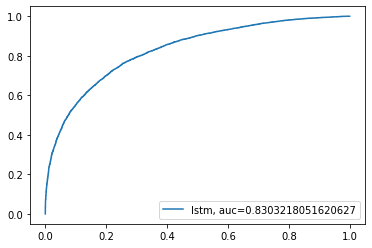

In [ ]:
fpr, tpr, _ = metrics.roc_curve(df_test['bought'],  df_test['pred_proba'])
auc = metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'])
print(auc)
plt.plot(fpr,tpr,label="lstm, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#weighted accuracy
sklearn.metrics.classification_report(df_test['bought'], predictions_x, sample_weight= df_test['sample_weight'], output_dict=True)

{'0': {'f1-score': 0.4356960172203371,
  'precision': 0.3648149366178918,
  'recall': 0.5407625275346036,
  'support': 233.8311516399456},
 '1': {'f1-score': 0.6695065069555655,
  'precision': 0.7554723865693768,
  'recall': 0.6011061048218749,
  'support': 551.9239419021508},
 'accuracy': 0.5831485907222209,
 'macro avg': {'f1-score': 0.5526012620879512,
  'precision': 0.5601436615936343,
  'recall': 0.5709343161782392,
  'support': 785.7550935420963},
 'weighted avg': {'f1-score': 0.599927351147829,
  'precision': 0.6392174845399237,
  'recall': 0.5831485907222215,
  'support': 785.7550935420963}}

0.6297250471528997


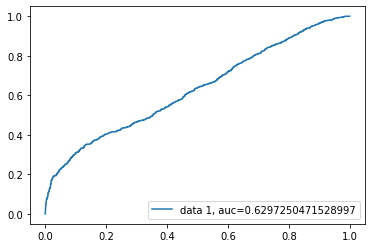

In [ ]:
# weighted AUC
fpr, tpr, _ = metrics.roc_curve(df_test['bought'],  df_test['pred_proba'], sample_weight=df_test['sample_weight'])
auc = metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'], sample_weight=df_test['sample_weight'])
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Grid search

In [ ]:
    def get_model(param):
        dim_embedddings = 100
        bias = 1

        # products
        product_input = Input(shape=[1],name='product_input')
        product_embedding = Embedding(n_products +1, dim_embedddings, name="product_embedding")(product_input)
        product_bias = Embedding(n_products + 1, bias, name="product_bias")(product_input)

        # users
        user_input = Input(shape=[1],name='User')
        user_embedding = Embedding(n_users+1, dim_embedddings, name="User-Embedding")(user_input)
        user_bias = Embedding(n_users + 1, bias, name="user_bias")(user_input)

        matrix_product = multiply([product_embedding, user_embedding])

        input_terms = concatenate([matrix_product, user_bias, product_bias])
        input_terms = Flatten()(input_terms)

        result = Dense(1, activation='sigmoid')(input_terms)

        model_mf = Model(inputs=[product_input, user_input], outputs=result)
        ## compile model
        model_mf.compile(optimizer=keras.optimizers.Adam(learning_rate=param['lr']), loss = ['binary_crossentropy'], metrics = ['AUC', keras.metrics.BinaryAccuracy()])   
        
        return model_mf

In [ ]:
param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'epochs': 200, 
    'batch_size': [512, 1024, 2048]
}
early = EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)
kgs = KerasRandomSearch(get_model, param_grid, monitor='val_binary_accuracy', greater_is_better=True, n_iter=9)

In [ ]:
kgs.search([df_train['product_id'], df_train['user_id']],
                          df_train['bought'],
                          validation_data = ([df_test['product_id'], df_test['user_id']],
                          df_test['bought']), callbacks=[early])


9 trials detected for ('lr', 'epochs', 'batch_size')

***** (1/9) *****
Search({'lr': 1e-05, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.66406 at epoch 41

***** (2/9) *****
Search({'lr': 1e-05, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.66904 at epoch 30

***** (3/9) *****
Search({'lr': 0.001, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.75271 at epoch 10

***** (4/9) *****
Search({'lr': 1e-05, 'epochs': 200, 'batch_size': 512})
SCORE: 0.66753 at epoch 26

***** (5/9) *****
Search({'lr': 0.0001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.75788 at epoch 32

***** (6/9) *****
Search({'lr': 0.0001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.75775 at epoch 52

***** (7/9) *****
Search({'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.75567 at epoch 5

***** (8/9) *****
Search({'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.74798 at epoch 4

***** (9/9) *****
Search({'lr': 0.0001, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.75176 at epoch 52


### Recall@N

In [ ]:
df['product_id'] = df['product_id'].astype('int')
df['user_id'] = df['user_id'].astype('int')

all_users = df[df['data_split'] == 'test']['user_id'].unique().tolist()
recall_matrix = np.zeros(shape=(len(all_users),2))
recall_matrix_weighted = np.zeros(shape=(len(all_users),2))
for user_id in all_users:
  max_date = max(df[df['user_id'] == user_id]['day'])
  df_train = df[(df['user_id'] == user_id) & (df['data_split'] == 'train')]
  df_train = df_train[['day','product_id', 'bought', 'data_split', 'sample_weight']]

  df_test = df[(df['user_id'] == user_id) & (df['bought'] == 1) & (df['day'] == max_date)]
  df_test = df_test[['day','product_id', 'bought', 'data_split', 'sample_weight']]
  bought_products = df_test['product_id'].unique()
  df_day = df[(df['day'] == max_date) & (df['bought'] == 1) & (df['user_id'] != user_id)]
  df_day = df_day[['product_id']].drop_duplicates()
  df_day = df_day.loc[~df_day['product_id'].isin(bought_products)]
  df_day['bought'] = 0
  df_day['data_split'] = 'test'

  df_test = df_test.append(df_day)
  train = df_train.append(df_test)
  train['user_id'] = user_id

  df_test = train[(train['data_split'] == 'test')]
  predictions = model_mf.predict([df_test['product_id'], df_test['user_id']]).ravel()
  df_test['ypred_proba'] = predictions
  df_test['sample_weight_for_only_bought'] = np.where(df_test['bought'] == 1, df_test['sample_weight'], 0)
  df_test['norm_weight'] = df_test['sample_weight_for_only_bought'] / df_test.groupby('day')['sample_weight_for_only_bought'].transform('sum')
  df_test['norm_weight'] = df_test['norm_weight'] * df_test.groupby('day')['bought'].transform('sum')

  recall_matrix_weighted[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['norm_weight'].sum() / df_test['bought'].sum()) * 100])
  recall_matrix[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['bought'].sum() / df_test['bought'].sum()) * 100])

In [ ]:
pd.DataFrame(recall_matrix)[1].mean() # recall@n

22.308075022847294

In [ ]:
pd.DataFrame(recall_matrix_weighted)[1].mean() #recall@n weighted

19.12021266885269

# Shopper Model

A detailed example of Shopper model can also be found in this blog: https://humboldt-wi.github.io/blog/research/information_systems_1920/group3_shopper/

In [ ]:
user = Input(name = 'user', shape = (1,))
item = Input(name = 'item', shape = (1,))
price = Input(name = 'price', shape = (1,))
week = Input(name = 'week', shape = (1,))
subcategory = Input(name = 'subcategory', shape = (1,)) # added to shopper+
discount = Input(name='discount', shape=(1,)) # added to shopper+
diffs = Input(name='diffs', shape=(1,)) # added to shopper+
other_prods = Input(name='other_prods', shape=(35,))

item popularity

In [ ]:
item_pop = Embedding(name = 'item_pop', 
                           input_dim = item_len, 
                           output_dim = 1)(item)
item_pop = Reshape(target_shape = (1, ))(item_pop)

user item interaction

In [ ]:
user_embedding_for_item = Embedding(name = 'user_embedding_for_item',
                               input_dim = user_len,
                               output_dim = embedding_size,
                               embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights),
                               trainable=True
                               )(user)

item_embedding_for_user = Embedding(name = 'item_embedding_for_user', 
                           input_dim = item_len, 
                           output_dim = embedding_size,
                           embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products),
                           trainable=True
                           )(item)

user_item_embedding = Dot(name = 'user_item_embedding', axes = 2)([item_embedding_for_user, user_embedding_for_item])

user_item_embedding = Reshape(target_shape = (1, ))(user_item_embedding)

item and other products in basket

In [ ]:
item_embedding_for_rest_basket = Embedding(name = 'item_embedding_for_rest_basket',
                               input_dim = item_len,
                               output_dim = embedding_size,
                           embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products),
                           trainable=True
                               )(item)


rest_basket_embedding_for_prev_basket = Embedding(name = 'rest_basket_embedding_for_prev_basket',
                               input_dim = item_len,
                               output_dim = embedding_size,
                           embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products),
                           trainable=True,
                          mask_zero=True
                               )(other_prods)

avg_basket_embedding = keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1))(rest_basket_embedding_for_prev_basket)
avg_basket_embedding = Reshape(target_shape=(1,embedding_size))(avg_basket_embedding)


item_rest_basket = Dot(name = 'item_rest_basket', axes = 2)([item_embedding_for_rest_basket, avg_basket_embedding])

item_rest_basket_embedding1 = Reshape(target_shape = (1,))(item_rest_basket)

user price sensitivity for item

In [ ]:
item_embedding_for_price = Embedding(name = 'item_embedding_for_price', 
                          input_dim = item_len, 
                          output_dim = embedding_size,
                          embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products),
                          trainable=True
                          )(item)

#results should be non negative - because if embedding weights are negative, this would mislead price effects (see shopper paper)
constraint_layer = nonneg()
constrained_item = constraint_layer(item_embedding_for_price)
user_embedding_for_price = Embedding(name = "user_embedding_for_price",
                                 input_dim = user_len,
                                 output_dim = embedding_size,
                                 embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights),
                                 trainable=True
                                 )(user)

constrained_user = constraint_layer(user_embedding_for_price)
user_item_price_embedding = Dot(name = 'user_item_price_embedding', axes = 2)([constrained_item, constrained_user])

user_item_price_embedding1 = Reshape(target_shape = (1,))(user_item_price_embedding)

user_item_price_embedding2 = multiply([price * -1, user_item_price_embedding1], name = 'user_item_price_embedding2')

subcategory discount user

In [ ]:
# added to shopper+
subcategory_embedding_for_discount = Embedding(name = 'subcategory_embedding_for_discount', 
                          input_dim = sub_len, 
                          output_dim = embedding_size)(subcategory)

#results should be non negative - because if embedding weights are negative, this would mislead discount effects 
constraint_layer = nonneg()
constrained_sub = constraint_layer(subcategory_embedding_for_discount)
user_embedding_for_discount = Embedding(name = "user_embedding_for_discount",
                                 input_dim = user_len,
                                 output_dim = embedding_size,
                                 embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights),
                                 trainable=True
                             )(user)

constrained_user = constraint_layer(user_embedding_for_discount)


user_subcategory_discount_embedding = Dot(name = 'user_subcategory_discount_embedding', axes = 2)([constrained_sub, constrained_user])
user_subcategory_discount_embedding1 = Reshape(target_shape = (1,))(user_subcategory_discount_embedding)
user_subcategory_discount_embedding2 = multiply([discount, user_subcategory_discount_embedding1], name = 'user_subcategory_discount_embedding2')

In [ ]:
# added to shopper+
subcategory_embedding_for_discount = Embedding(name = 'subcategory_embedding_for_discount_diff', 
                          input_dim = sub_len, 
                          output_dim = embedding_size)(subcategory)

constraint_layer = nonneg()
constrained_sub = constraint_layer(subcategory_embedding_for_discount)
user_embedding_for_discount = Embedding(name = "user_embedding_for_discount_diff",
                                 input_dim = user_len,
                                 output_dim = embedding_size,
                                 embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights),
                                 trainable=True
                             )(user)

constrained_user = constraint_layer(user_embedding_for_discount)


user_subcategory_discount_diff_embedding = Dot(name = 'user_subcategory_discount_diff_embedding', axes = 2)([constrained_sub, constrained_user])
user_subcategory_discount_diff_embedding1 = Reshape(target_shape = (1,))(user_subcategory_discount_diff_embedding)
user_subcategory_discount_diff_embedding2 = multiply([diffs, user_subcategory_discount_diff_embedding1], name = 'user_subcategory_discount_diff_embedding2')

week item interaction

In [ ]:
week_embedding = Embedding(name = 'week_embedding',
                               input_dim = day_len,
                               output_dim = embedding_size)(week)

week_item_embedding = Embedding(name = 'week_item_embedding', 
                           input_dim = item_len, 
                           output_dim = embedding_size,
                           embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products),
                           trainable=True
                           )(item)


week_item_embedding1 = Dot(name = 'week_item_embedding1', axes = 2)([week_item_embedding, week_embedding])

week_item_embedding2 = Reshape(target_shape = (1, ))(week_item_embedding1)

In [ ]:
x = keras.layers.add([item_pop,
                      user_item_embedding, 
                      user_item_price_embedding2,  
                      week_item_embedding2, 
                      item_rest_basket_embedding1, 
                      user_subcategory_discount_embedding2, # added to shopper+
                      user_subcategory_discount_diff_embedding2 # added to shopper+
                      ]) 

In [ ]:
out = Dense(1, activation = 'sigmoid', name = 'output')(x)
model = Model(inputs = [
                        user, 
                        item, 
                        price, 
                        week,
                        subcategory, # added to shopper+ 
                        discount, # added to shopper+
                        diffs , # added to shopper+
                        other_prods], outputs = out) 
    
model.compile(optimizer = Adam(lr=0.001), loss = 'binary_crossentropy',
              metrics = [keras.metrics.AUC(), keras.metrics.BinaryAccuracy()])

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding_for_price (Embed (None, 1, 100)       1190400     item[0][0]                       
__________________________________________________________________________________________________
user_embedding_for_price (Embed (None, 1, 100)       100000      user[0][0]                       
______________________________________________________________________________________________

In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)

history = model.fit({'user': df_train['user_id'], 
                     'item': df_train['product_id'], 
                     'price': df_train['price'], 
                     'week': df_train['week'], 
                     'subcategory': df_train['subcategory_name'], # added to shopper+
                     'discount': df_train['discount'], # added to shopper+
                     'diffs': df_train['diffs'],  # added to shopper+
                     'other_prods': tf.convert_to_tensor(df_train['other_prods_in_basket'].tolist())},
          {'output': df_train['bought']},
          epochs=200, validation_data=
          (
              {'user': df_test['user_id'], 
               'item': df_test['product_id'], 
               'price': df_test['price'], 
               'week': df_test['week'], 
               'subcategory': df_test['subcategory_name'], # added to shopper+
               'discount': df_test['discount'], # added to shopper+    
               'diffs': df_test['diffs'],  # added to shopper+
               'other_prods': tf.convert_to_tensor(df_test['other_prods_in_basket'].tolist())},
          {'output': df_test['bought']}), batch_size = 1024, callbacks=[early_stopping_monitor]
          )

Epoch 1/200
1176/1176 [==============================] - 31s 24ms/step - loss: 0.6068 - auc: 0.7279 - binary_accuracy: 0.6638 - val_loss: 0.5370 - val_auc: 0.8000 - val_binary_accuracy: 0.7182
Epoch 2/200
1176/1176 [==============================] - 30s 26ms/step - loss: 0.3491 - auc: 0.9288 - binary_accuracy: 0.8510 - val_loss: 0.5189 - val_auc: 0.8305 - val_binary_accuracy: 0.7470
Epoch 3/200
1176/1176 [==============================] - 30s 25ms/step - loss: 0.2227 - auc: 0.9728 - binary_accuracy: 0.9156 - val_loss: 0.5636 - val_auc: 0.8345 - val_binary_accuracy: 0.7492
Epoch 4/200
1176/1176 [==============================] - 32s 27ms/step - loss: 0.1536 - auc: 0.9868 - binary_accuracy: 0.9452 - val_loss: 0.6400 - val_auc: 0.8327 - val_binary_accuracy: 0.7499
Epoch 5/200
1176/1176 [==============================] - 32s 27ms/step - loss: 0.1150 - auc: 0.9923 - binary_accuracy: 0.9597 - val_loss: 0.7234 - val_auc: 0.8289 - val_binary_accuracy: 0.7520
Epoch 6/200
1176/1176 [============

## Evaluation

In [ ]:
predictions = model.predict({'user': df_test['user_id'], 
                             'item': df_test['product_id'], 
                             'price': df_test['price'], 
                             'week': df_test['week'], 
                             'subcategory': df_test['subcategory_name'], 
                             'discount': df_test['discount'], 
                             'diffs': df_test['diffs'],
                             'other_prods': tf.convert_to_tensor(df_test['other_prods_in_basket'].tolist())})
df_test['pred_proba']  = predictions
predictions_x = np.where(predictions > 0.5, 1, 0)
df_test['pred'] = predictions_x

0.8360131985191004


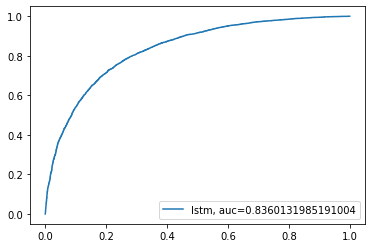

In [ ]:
fpr, tpr, _ = metrics.roc_curve(df_test['bought'],  df_test['pred_proba'])
auc = metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'])
print(auc)
plt.plot(fpr,tpr,label="lstm, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
sklearn.metrics.classification_report(df_test['bought'], predictions_x, output_dict=True)

{'0': {'f1-score': 0.7548113933795229,
  'precision': 0.7688186095138526,
  'recall': 0.7413054435483871,
  'support': 7936},
 '1': {'f1-score': 0.7634315424610053,
  'precision': 0.7502433090024331,
  'recall': 0.7770917338709677,
  'support': 7936},
 'accuracy': 0.7591985887096774,
 'macro avg': {'f1-score': 0.759121467920264,
  'precision': 0.7595309592581428,
  'recall': 0.7591985887096775,
  'support': 15872},
 'weighted avg': {'f1-score': 0.759121467920264,
  'precision': 0.7595309592581428,
  'recall': 0.7591985887096774,
  'support': 15872}}

0.6821032610850198


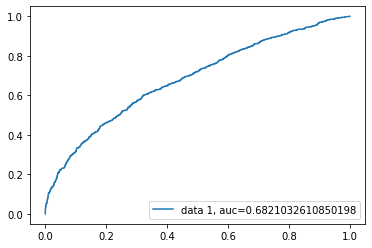

In [ ]:
#weighted AUC
fpr, tpr, _ = metrics.roc_curve(df_test['bought'],  df_test['pred_proba'], sample_weight=df_test['sample_weight'])
auc = metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'], sample_weight=df_test['sample_weight'])
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#weighted accuracy
sklearn.metrics.classification_report(df_test['bought'], predictions_x, sample_weight= df_test['sample_weight'], output_dict=True)

{'0': {'f1-score': 0.49122759361820517,
  'precision': 0.4210672962398838,
  'recall': 0.5894435715283158,
  'support': 233.8311516399456},
 '1': {'f1-score': 0.7174168105048391,
  'precision': 0.7905829474737431,
  'recall': 0.656646133503124,
  'support': 551.9239419021508},
 'accuracy': 0.6366474690479097,
 'macro avg': {'f1-score': 0.6043222020615221,
  'precision': 0.6058251218568135,
  'recall': 0.62304485251572,
  'support': 785.7550935420963},
 'weighted avg': {'f1-score': 0.6501056527308354,
  'precision': 0.6806195874050264,
  'recall': 0.6366474690479094,
  'support': 785.7550935420963}}

## Grid search

In [ ]:
def get_model(param):
    user = Input(name = 'user', shape = (1,))
    item = Input(name = 'item', shape = (1,))
    price = Input(name = 'price', shape = (1,))
    week = Input(name = 'week', shape = (1,))
    subcategory = Input(name = 'subcategory', shape = (1,))
    discount = Input(name='discount', shape=(1,))
    diffs = Input(name='diffs', shape=(1,))
    other_prods = Input(name='other_prods', shape=(35,))

    item_pop = Embedding(name = 'item_pop', 
                              input_dim = item_len, 
                              output_dim = 1)(item)
    item_pop = Reshape(target_shape = (1, ))(item_pop)
    user_embedding_for_item = Embedding(name = 'user_embedding_for_item',
                                  input_dim = user_len,
                                  output_dim = embedding_size,
                                  embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights),
                                  )(user)
    item_embedding_for_user = Embedding(name = 'item_embedding_for_user', 
                              input_dim = item_len, 
                              output_dim = embedding_size,
                              embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights),
                              )(item)
    user_item_embedding = Dot(name = 'user_item_embedding', axes = 2)([item_embedding_for_user, user_embedding_for_item])
    user_item_embedding = Reshape(target_shape = (1, ))(user_item_embedding)
    item_embedding_for_rest_basket = Embedding(name = 'item_embedding_for_rest_basket',
                                  input_dim = item_len,
                                  output_dim = embedding_size,
                                  embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights),
                                  )(item)
    rest_basket_embedding_for_prev_basket = Embedding(name = 'rest_basket_embedding_for_prev_basket',
                                  input_dim = item_len,
                                  output_dim = embedding_size,
                                  embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights),
                                  mask_zero=True
                                  )(other_prods)
    avg_basket_embedding = keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1))(rest_basket_embedding_for_prev_basket)
    avg_basket_embedding = Reshape(target_shape=(1,embedding_size))(avg_basket_embedding)
    item_rest_basket = Dot(name = 'item_rest_basket', axes = 2)([item_embedding_for_rest_basket, avg_basket_embedding])
    item_rest_basket_embedding1 = Reshape(target_shape = (1,))(item_rest_basket)
    item_embedding_for_price = Embedding(name = 'item_embedding_for_price', 
                              input_dim = item_len, 
                              output_dim = embedding_size,
                             embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights),
                              )(item)
    constraint_layer = nonneg()
    constrained_item = constraint_layer(item_embedding_for_price)
    user_embedding_for_price = Embedding(name = "user_embedding_for_price",
                                    input_dim = user_len,
                                    output_dim = embedding_size,
                                    embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights),
                                    )(user)
    constrained_user = constraint_layer(user_embedding_for_price)
    user_item_price_embedding = Dot(name = 'user_item_price_embedding', axes = 2)([constrained_item, constrained_user])
    user_item_price_embedding1 = Reshape(target_shape = (1,))(user_item_price_embedding)
    user_item_price_embedding2 = multiply([price * -1, user_item_price_embedding1], name = 'user_item_price_embedding2')
    week_embedding = Embedding(name = 'week_embedding',
                                  input_dim = day_len,
                                  output_dim = embedding_size)(week)
    week_item_embedding = Embedding(name = 'week_item_embedding', 
                              input_dim = item_len, 
                              output_dim = embedding_size,
                              embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights),
                              )(item)
    week_item_embedding1 = Dot(name = 'week_item_embedding1', axes = 2)([week_item_embedding, week_embedding])
    week_item_embedding2 = Reshape(target_shape = (1, ))(week_item_embedding1)
    x = keras.layers.add([item_pop,
                          user_item_embedding, 
                          user_item_price_embedding2,  
                          week_item_embedding2, 
                          item_rest_basket_embedding1, 
                          user_subcategory_discount_embedding2,
                          user_subcategory_discount_diff_embedding2
                          ]) 
    out = Dense(1, activation = 'sigmoid', name = 'output')(x)
    model = Model(inputs = [
                            user, 
                            item, 
                            price, 
                            week,
                            subcategory, 
                            discount, 
                            diffs ,
                            other_prods], outputs = out)         
    model.compile( optimizer=keras.optimizers.Adam(learning_rate=param['lr']), loss = 'binary_crossentropy',
                  metrics = ['AUC', keras.metrics.BinaryAccuracy()])  
    return model

In [ ]:
param_grid = {
    'lr': [1e-3, 5e-4, 1e-4, 5e-5, 1e-5],
    'epochs': 200, 
    'batch_size': [512, 1024, 2048]
}
early = EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)
kgs = KerasRandomSearch(get_model, param_grid, monitor='val_binary_accuracy', greater_is_better=True, n_iter=15)

In [ ]:
kgs.search({'user': df_train['user_id'], 
                     'item': df_train['product_id'], 
                     'price': df_train['price'], 
                     'week': df_train['week'], 
                     'subcategory': df_train['subcategory_name'], 
                     'discount': df_train['discount'], 
                     'diffs': df_train['diffs'], 
                     'other_prods': tf.convert_to_tensor(df_train['other_prods_in_basket'].tolist())},
          {'output': df_train['bought']},
           validation_data=
          (
              {'user': df_test['user_id'], 
               'item': df_test['product_id'], 
               'price': df_test['price'], 
               'week': df_test['week'], 
               'subcategory': df_test['subcategory_name'], 
               'discount': df_test['discount'],                
               'diffs': df_test['diffs'], 
               'other_prods': tf.convert_to_tensor(df_test['other_prods_in_basket'].tolist())},
          {'output': df_test['bought']}), callbacks=[early]
          )


15 trials detected for ('lr', 'epochs', 'batch_size')

***** (1/15) *****
Search({'lr': 1e-05, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.65367 at epoch 25

***** (2/15) *****
Search({'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.75372 at epoch 2

***** (3/15) *****
Search({'lr': 0.0005, 'epochs': 200, 'batch_size': 512})
SCORE: 0.75334 at epoch 4

***** (4/15) *****
Search({'lr': 1e-05, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.73923 at epoch 168

***** (5/15) *****
Search({'lr': 5e-05, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.74716 at epoch 59

***** (6/15) *****
Search({'lr': 0.001, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.75139 at epoch 5

***** (7/15) *****
Search({'lr': 0.0001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.75038 at epoch 29

***** (8/15) *****
Search({'lr': 0.0001, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.75347 at epoch 40

***** (9/15) *****
Search({'lr': 5e-05, 'epochs': 200, 'batch_size': 512})
SCORE: 0.75006 at epoch 36

***** (10/

## Recall@N

In [ ]:
all_users = df[df['data_split'] == 'test']['user_id'].unique().tolist()
recall_matrix = np.zeros(shape=(len(all_users),2))
recall_matrix_weighted = np.zeros(shape=(len(all_users),2))
df['day'] = df['day'].astype('int')
df['user_id'] = df['user_id'].astype('int')
df['product_id'] = df['product_id'].astype('int')
df['week'] = df['week'].astype('int')

In [ ]:
for user_id in all_users:
  max_date = max(df[df['user_id'] == user_id]['day'])
  df_test = df[(df['user_id'] == user_id) & (df['day'] == max_date)]
  actual_basket = df_test[df_test['user_id'] == user_id].head(1)['basket']
  df_test = df_test[['day', 'week', 'product_id', 'subcategory_name', 'category_name', 'price', 'discount', 'diffs', 'other_prods_in_basket', 'bought', 'sample_weight']]
  considered_products = df_test['product_id'].unique().tolist()

  df_test_max_others = df[(df['day'] == max_date) & (df['bought'] == 1) & (df['user_id'] != user_id)]
  df_test_max_others = df_test_max_others.groupby(['day', 'week', 'product_id', 'subcategory_name', 'category_name'], as_index=False).aggregate({
        'price' : 'first',
        'discount': 'first',
        'diffs' : 'first',
    })
  df_test_max_others = df_test_max_others[~df_test_max_others['product_id'].isin(considered_products)]
  df_test_max_others['other_prods_in_basket'] = df_test_max_others.product_id.apply(lambda x: actual_basket)
  df_test_max_others['bought'] = 0

  #append two datasets
  df_test = df_test.append(df_test_max_others)
  df_test['user_id'] = user_id

  predictions = model.predict(
                {'user': df_test['user_id'], 
                'item': df_test['product_id'], 
                'price': df_test['price'], 
                'week': df_test['week'], 
                'subcategory': df_test['subcategory_name'], 
                'discount': df_test['discount'],                
                'diffs': df_test['diffs'], 
                'other_prods': tf.convert_to_tensor(df_test['other_prods_in_basket'].tolist())}
            )
  df_test['ypred_proba'] = predictions
  df_test['sample_weight_for_only_bought'] = np.where(df_test['bought'] == 1, df_test['sample_weight'], 0)
  df_test['norm_weight'] = df_test['sample_weight_for_only_bought'] / df_test.groupby('day')['sample_weight_for_only_bought'].transform('sum')
  df_test['norm_weight'] = df_test['norm_weight'] * df_test.groupby('day')['bought'].transform('sum')

  recall_matrix_weighted[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['norm_weight'].sum() / df_test['bought'].sum()) * 100])

  recall_matrix[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['bought'].sum() / df_test['bought'].sum()) * 100])

In [ ]:
pd.DataFrame(recall_matrix)[1].mean() # recall@n

26.56528336823728

In [ ]:
pd.DataFrame(recall_matrix_weighted)[1].mean() #recall@n weighted

21.753004708689158

# Wide and Deep Model

In [ ]:
product_wide_train = np.asarray(df_train['product_id'].tolist())
user_wide_train = np.asarray(df_train['user_id'].tolist())

product_wide_test = np.asarray(df_test['product_id'].tolist())
user_wide_test = np.asarray(df_test['user_id'].tolist())

## Wide model

In [ ]:
products = Input((1,), dtype='int32')
product_onehot = Lambda(lambda x: tf.one_hot(x[:,0], item_len))(products)
users = Input((1,), dtype='int32')
user_onehot = Lambda(lambda x: tf.one_hot(x[:,0], user_len))(users)
x = concatenate([product_onehot, user_onehot], axis=-1)
predictions = Dense(1, activation = 'sigmoid')(x)
wide_model = Model(inputs=[products, users], outputs=predictions)
wide_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001), metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

wide_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 11904)        0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1000)         0           input_2[0][0]                    
______________________________________________________________________________________________

## Deep model

In [ ]:
discount = tf.keras.Input(shape=(1,), name = 'discount')
price = tf.keras.Input(shape=(1,), name = 'price')
diffs = tf.keras.Input(shape=(1,), name = 'diffs')

week = tf.keras.Input(shape=(1,), name = 'week')
embedding_week = tf.keras.layers.Embedding(week_len + 1, embedding_size,   input_length=1)(week)
embedding_week = tf.keras.layers.Flatten()(embedding_week)

subcategory_name = tf.keras.Input(shape=(1,), name = 'subcategory_name')
embedding_subcategory_name = tf.keras.layers.Embedding(sub_len, embedding_size,   input_length=1)(subcategory_name)
embedding_subcategory_name = tf.keras.layers.Flatten()(embedding_subcategory_name)

users_deep = tf.keras.Input(shape=(1,), name = 'users_deep')
embedding_users_deep = tf.keras.layers.Embedding(user_len, embedding_size,   input_length=1,  
                                 embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights), trainable=True
                                 )(users_deep)
embedding_users_deep = tf.keras.layers.Flatten()(embedding_users_deep)

products_deep = tf.keras.Input(shape=(1,), name = 'products_deep')
embedding_products_deep = tf.keras.layers.Embedding(item_len, embedding_size, input_length=1, 
                                    embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products), trainable=True
                                    )(products_deep)
embedding_products_deep2 = tf.keras.layers.Flatten()(embedding_products_deep)

merged_layer_deep = tf.keras.layers.concatenate([discount, price, diffs, embedding_week, embedding_subcategory_name, 
                                 embedding_users_deep, embedding_products_deep2
                                 ])

merged_layer_deep = tf.keras.layers.Dense(256, activation='relu')(merged_layer_deep)
embed_out = tf.keras.layers.Dense(1, activation='sigmoid')(merged_layer_deep)
deep_model = tf.keras.Model(inputs=[discount, price, diffs, week, subcategory_name, 
                           users_deep, products_deep
                           ], outputs=embed_out)
deep_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001), metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

In [ ]:
deep_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
week (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
subcategory_name (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_deep (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
products_deep (InputLayer)      [(None, 1)]          0                                            
____________________________________________________________________________________________

## Wide and Deep combined

In [ ]:
merged_out = tf.keras.layers.concatenate([wide_model.output, deep_model.output])
merged_out = tf.keras.layers.Dense(1, activation='sigmoid')(merged_out)
combined_model = tf.keras.Model(wide_model.inputs + [deep_model.inputs], merged_out)
combined_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), metrics=['AUC', tf.keras.metrics.BinaryAccuracy()])

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)
## Training
combined_model.fit([product_wide_train, user_wide_train] + 
                   [df_train['discount'], df_train['price'], df_train['diffs'],
                    df_train['week'], df_train['subcategory_name'], 
                    df_train['user_id'], df_train['product_id']], df_train['bought'],
                   validation_data=([product_wide_test, user_wide_test] + 
                                    [df_test['discount'], df_test['price'], df_test['diffs'],
                                     df_test['week'], df_test['subcategory_name'] , 
                                     df_test['user_id'], df_test['product_id']], df_test['bought']),
                   epochs=200, 
                   batch_size=512,
                   callbacks=[early],
                   )


Epoch 1/200
2352/2352 [==============================] - 34s 14ms/step - loss: 0.6118 - auc: 0.7276 - binary_accuracy: 0.6696 - val_loss: 0.5835 - val_auc: 0.7647 - val_binary_accuracy: 0.6966
Epoch 2/200
2352/2352 [==============================] - 27s 12ms/step - loss: 0.5253 - auc: 0.8208 - binary_accuracy: 0.7457 - val_loss: 0.5625 - val_auc: 0.7860 - val_binary_accuracy: 0.7142
Epoch 3/200
2352/2352 [==============================] - 27s 12ms/step - loss: 0.4896 - auc: 0.8462 - binary_accuracy: 0.7703 - val_loss: 0.5516 - val_auc: 0.7975 - val_binary_accuracy: 0.7252
Epoch 4/200
2352/2352 [==============================] - 27s 12ms/step - loss: 0.4666 - auc: 0.8614 - binary_accuracy: 0.7860 - val_loss: 0.5478 - val_auc: 0.8037 - val_binary_accuracy: 0.7322
Epoch 5/200
2352/2352 [==============================] - 28s 12ms/step - loss: 0.4450 - auc: 0.8750 - binary_accuracy: 0.8003 - val_loss: 0.5455 - val_auc: 0.8082 - val_binary_accuracy: 0.7347
Epoch 6/200
2352/2352 [============

## Grid search

In [ ]:
def get_model(param):

    # wide model
    products = Input((1,), dtype='int32')
    product_onehot = Lambda(lambda x: tf.one_hot(x[:,0], item_len))(products)
    users = Input((1,), dtype='int32')
    user_onehot = Lambda(lambda x: tf.one_hot(x[:,0], user_len))(users)

    x = concatenate([product_onehot, user_onehot], axis=-1)
    predictions = Dense(1, activation = 'sigmoid')(x)
    wide_model = Model(inputs=[products, users], outputs=predictions)
    wide_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(
        learning_rate=param['wide_lr']), metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])


    # deep model
    discount = tf.keras.Input(shape=(1,), name = 'discount')
    price = tf.keras.Input(shape=(1,), name = 'price')
    diffs = tf.keras.Input(shape=(1,), name = 'diffs')

    week = tf.keras.Input(shape=(1,), name = 'week')
    embedding_week = tf.keras.layers.Embedding(week_len + 1, embedding_size,   input_length=1)(week)
    embedding_week = tf.keras.layers.Flatten()(embedding_week)

    subcategory_name = tf.keras.Input(shape=(1,), name = 'subcategory_name')
    embedding_subcategory_name = tf.keras.layers.Embedding(sub_len, embedding_size,   input_length=1)(subcategory_name)
    embedding_subcategory_name = tf.keras.layers.Flatten()(embedding_subcategory_name)

    users_deep = tf.keras.Input(shape=(1,), name = 'users_deep')
    embedding_users_deep = tf.keras.layers.Embedding(user_len, embedding_size,   input_length=1,  
                                    # embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights)
                                    )(users_deep)
    embedding_users_deep = tf.keras.layers.Flatten()(embedding_users_deep)

    products_deep = tf.keras.Input(shape=(1,), name = 'products_deep')
    embedding_products_deep = tf.keras.layers.Embedding(item_len, embedding_size, input_length=1, 
                                      #  embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights)
                                        )(products_deep)
    embedding_products_deep2 = tf.keras.layers.Flatten()(embedding_products_deep)

    merged_layer_deep = tf.keras.layers.concatenate([discount, price, diffs, embedding_week, embedding_subcategory_name, 
                                    embedding_users_deep, embedding_products_deep2
                                    ])

    merged_layer_deep = tf.keras.layers.Dense(256, activation='relu')(merged_layer_deep)
    embed_out = tf.keras.layers.Dense(1, activation='sigmoid')(merged_layer_deep)
    deep_model = tf.keras.Model(inputs=[discount, price, diffs, week, subcategory_name, 
                              users_deep, products_deep
                              ], outputs=embed_out)
    deep_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(
        learning_rate=param['deep_lr']), metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

    # merged model
    merged_out = tf.keras.layers.concatenate([wide_model.output, deep_model.output])
    merged_out = tf.keras.layers.Dense(1, activation='sigmoid')(merged_out)
    combined_model = tf.keras.Model(wide_model.inputs + [deep_model.inputs], merged_out)
    combined_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(
        learning_rate=param['combined_lr']), metrics=['AUC', tf.keras.metrics.BinaryAccuracy()])

    return combined_model

In [ ]:
param_grid = {
    'wide_lr': [1e-3, 1e-4, 1e-5], 
    'deep_lr': [1e-3, 1e-4, 1e-5],
    'combined_lr': [1e-1, 1e-2, 1e-3, 1e-4], 
    'epochs': 100, 
    'batch_size': [512, 1024, 2048]
}
early = tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)
kgs = KerasRandomSearch(get_model, param_grid, monitor='val_binary_accuracy', greater_is_better=True, n_iter=18)


In [ ]:
kgs.search([product_wide_train, user_wide_train] + 
                   [df_train['discount'], df_train['price'], df_train['diffs'],
                    df_train['week'], df_train['subcategory_name'], 
                    df_train['user_id'], df_train['product_id']], df_train['bought'],
                   validation_data=([product_wide_test, user_wide_test] + 
                                    [df_test['discount'], df_test['price'], df_test['diffs'],
                                     df_test['week'], df_test['subcategory_name'] , 
                                     df_test['user_id'], df_test['product_id']], df_test['bought'])
           , callbacks=[early])

# best params :Search({'wide_lr': 0.0001, 'deep_lr': 0.0001, 'combined_lr': 0.001, 'epochs': 100, 'batch_size': 512})


18 trials detected for ('wide_lr', 'deep_lr', 'combined_lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'wide_lr': 1e-05, 'deep_lr': 0.0001, 'combined_lr': 0.0001, 'epochs': 100, 'batch_size': 2048})
SCORE: 0.66935 at epoch 42

***** (2/18) *****
Search({'wide_lr': 0.001, 'deep_lr': 1e-05, 'combined_lr': 0.1, 'epochs': 100, 'batch_size': 512})
SCORE: 0.66828 at epoch 32

***** (3/18) *****
Search({'wide_lr': 0.001, 'deep_lr': 0.001, 'combined_lr': 0.01, 'epochs': 100, 'batch_size': 512})
SCORE: 0.65171 at epoch 9

***** (4/18) *****
Search({'wide_lr': 0.001, 'deep_lr': 0.001, 'combined_lr': 0.1, 'epochs': 100, 'batch_size': 1024})
SCORE: 0.66734 at epoch 20

***** (5/18) *****
Search({'wide_lr': 1e-05, 'deep_lr': 1e-05, 'combined_lr': 0.01, 'epochs': 100, 'batch_size': 2048})
SCORE: 0.70086 at epoch 21

***** (6/18) *****
Search({'wide_lr': 1e-05, 'deep_lr': 0.001, 'combined_lr': 0.01, 'epochs': 100, 'batch_size': 2048})
SCORE: 0.73204 at epoch 16

***** (7/18) *****
Search({

## Evaluation

In [ ]:
predictions = combined_model.predict([product_wide_test, user_wide_test] + 
                                    [df_test['discount'], df_test['price'], df_test['diffs'],
                                     df_test['week'], df_test['subcategory_name'] , 
                                     df_test['user_id'], df_test['product_id']])
df_test['pred_proba']  = predictions
predictions_x = np.where(predictions > 0.5, 1, 0)

0.7505135387488328


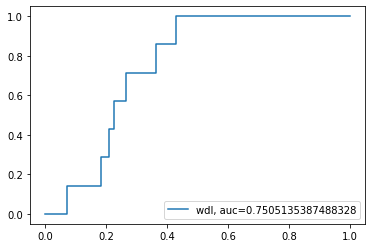

In [ ]:
fpr, tpr, _ = metrics.roc_curve(df_test['bought'],  df_test['pred_proba'])
auc = metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'])
print(auc)
plt.plot(fpr,tpr,label="wdl, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
sklearn.metrics.classification_report(df_test['bought'], predictions_x, output_dict=True)

{'0': {'f1-score': 0.741834850703508,
  'precision': 0.7497104619740059,
  'recall': 0.7341229838709677,
  'support': 7936},
 '1': {'f1-score': 0.7471472220490116,
  'precision': 0.7395383286014072,
  'recall': 0.754914314516129,
  'support': 7936},
 'accuracy': 0.7445186491935484,
 'macro avg': {'f1-score': 0.7444910363762598,
  'precision': 0.7446243952877065,
  'recall': 0.7445186491935484,
  'support': 15872},
 'weighted avg': {'f1-score': 0.7444910363762598,
  'precision': 0.7446243952877066,
  'recall': 0.7445186491935484,
  'support': 15872}}

In [ ]:
#weighted AUC
fpr, tpr, _ = metrics.roc_curve(df_test['bought'],  df_test['pred_proba'], sample_weight=df_test['sample_weight'])
auc = metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'] , sample_weight=df_test['sample_weight'])
print(auc)
plt.plot(fpr,tpr,label="wdl, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#weighted accuracy
sklearn.metrics.classification_report(df_test['bought'], predictions_x, sample_weight= df_test['sample_weight'], output_dict=True)

{'0': {'f1-score': 0.48966491182352445,
  'precision': 0.4017866659059972,
  'recall': 0.6267459545683881,
  'support': 233.8311516399456},
 '1': {'f1-score': 0.686021188219189,
  'precision': 0.7926890618291674,
  'recall': 0.6046559165287,
  'support': 551.9239419021508},
 'accuracy': 0.611229642969727,
 'macro avg': {'f1-score': 0.5878430500213567,
  'precision': 0.5972378638675824,
  'recall': 0.6157009355485441,
  'support': 785.7550935420963},
 'weighted avg': {'f1-score': 0.6275879504092329,
  'precision': 0.6763612668600192,
  'recall': 0.6112296429697285,
  'support': 785.7550935420963}}

## Recall@N

In [ ]:
all_users = df[df['data_split'] == 'test']['user_id'].unique().tolist()
recall_matrix = np.zeros(shape=(len(all_users),2))
recall_matrix_weighted = np.zeros(shape=(len(all_users),2))
df['day'] = df['day'].astype('int')
df['user_id'] = df['user_id'].astype('int')
df['product_id'] = df['product_id'].astype('int')
for user_id in all_users:
  max_date = max(df[df['user_id'] == user_id]['day'])
  df_test = df[(df['user_id'] == user_id) & (df['bought'] == 1) & (df['day'] == max_date)]
  df_test = df_test[['day', 'week', 'product_id', 'subcategory_name', 'category_name', 'price', 'discount', 'diffs', 'bought', 'data_split', 'sample_weight']]
  bought_products = df_test['product_id'].unique()
  df_day = df[(df['day'] == max_date) & (df['bought'] == 1) & (df['user_id'] != user_id)]
  df_day = df_day.groupby(['day', 'week', 'product_id', 'subcategory_name', 'category_name'], as_index=False).aggregate({
      'price' : 'first',
      'discount': 'first',
      'diffs' : 'first',
  })
  df_day = df_day.loc[~df_day['product_id'].isin(bought_products)]
  df_day['bought'] = 0
  df_day['data_split'] = 'test'
  df_test = df_test.append(df_day)
  df_test['user_id'] = user_id
  product_wide_test = np.asarray(df_test['product_id'].tolist())
  user_wide_test = np.asarray(df_test['user_id'].tolist())
  df_test['week'] = df_test['week'].astype('int')

  df_test['product_id'] = df_test['product_id'].astype('int')
  predictions = combined_model.predict([product_wide_test, user_wide_test] + [df_test['discount'], df_test['price'], df_test['diffs'], df_test['week'], df_test['subcategory_name'] , df_test['user_id'], df_test['product_id']])
  df_test['ypred_proba'] = predictions
  df_test['sample_weight_for_only_bought'] = np.where(df_test['bought'] == 1, df_test['sample_weight'], 0)
  df_test['norm_weight'] = df_test['sample_weight_for_only_bought'] / df_test.groupby('day')['sample_weight_for_only_bought'].transform('sum')
  df_test['norm_weight'] = df_test['norm_weight'] * df_test.groupby('day')['bought'].transform('sum')

  recall_matrix_weighted[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['norm_weight'].sum() / df_test['bought'].sum()) * 100])
  recall_matrix[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['bought'].sum() / df_test['bought'].sum()) * 100])


In [ ]:
pd.DataFrame(recall_matrix)[1].mean() # recall@n

17.673753671191776

In [ ]:
pd.DataFrame(recall_matrix_weighted)[1].mean() #recall@n weighted

12.617562447155448

# LSTM

### Model

In [ ]:
x_train = np.stack((df_train['30_day_purchase_history']) , axis=0 )
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = np.stack((df_test['30_day_purchase_history']) , axis=0 )
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

features = x_train.shape[2]

In [ ]:
#multiple input model
discount = Input(shape=(1,), name='discount')
price = Input(shape=(1,), name='price')
diffs = Input(shape=(1,), name='diffs')

product = Input(shape = (1,), name='product')
product_emb = Embedding(name = 'product_emb', input_dim = item_len, output_dim = 100,
                          #embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products),
                          #trainable=True
                        )(product)
product_emb = Flatten()(product_emb)

user = Input(shape = (1,), name='user')
user_emb = Embedding(name = 'user_emb',  input_dim = user_len,  output_dim = 100,
                          #embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights),
                          #trainable=True
                     )(user)
user_emb = Flatten()(user_emb)

week = Input(shape = (1,), name='week')
week_emb = Embedding(name = 'week_emb', input_dim = week_len, output_dim = 100)(week)
week_emb = Flatten()(week_emb)

subcategory = Input(shape=(1,), name='subcategory')
subcategory_emb = Embedding(name = 'subcategory_emb', input_dim = subcat_len, output_dim = 100)(subcategory)
subcategory_emb = Flatten()(subcategory_emb)


purchase_history = Input(shape=(1,30), name='purchase_history')
lstm_out = LSTM(128, input_dim=features, #return_sequences=True,
)(purchase_history)                                        


x = concatenate([
                 discount, 
                 price, 
                 diffs, 
                 product_emb, user_emb, week_emb, subcategory_emb, 
                 lstm_out,
                 ])

x = Dense(units=256, activation='relu')(x)
x = Dense(units=1, activation='sigmoid')(x)
model = Model(inputs=[
                     discount, 
                     price, 
                     diffs, 
                     product, user, week, subcategory, 
                     purchase_history,
                      ], outputs=[x])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
week (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
subcategory (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['AUC', keras.metrics.BinaryAccuracy()])

early = EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)

model.fit([
                     df_train['discount'],
                     df_train['price'], 
                     df_train['diffs'], 
                     df_train['product_id'], df_train['user_id'],
                     df_train['week'],  df_train['subcategory_name']
                     ,x_train
                     ],
                    df_train['bought'],

                    validation_data= ([
                    df_test['discount'],
                    df_test['price'], 
                    df_test['diffs'], 
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'],  df_test['subcategory_name']
                     ,x_test
                     ],
                    df_test['bought'],), 
                    batch_size=512, epochs=200, callbacks=[early]
                    )

## Evaluation

In [ ]:
predictions = model.predict([
                             df_test['discount'],
                             df_test['price'], 
                             df_test['diffs'], 
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'],  df_test['subcategory_name']
                     ,x_test
                     ])
df_test['pred_proba']  = predictions
predictions_x = np.where(predictions > 0.5, 1, 0)
df_test['pred'] = predictions_x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0.8680102959556942


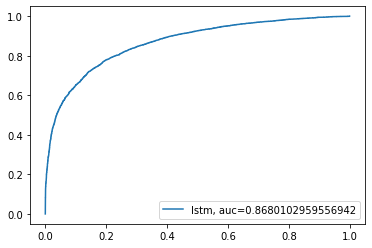

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(df_test['bought'],  df_test['pred_proba'])
auc = sklearn.metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'])
print(auc)
plt.plot(fpr,tpr,label="lstm, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
sklearn.metrics.classification_report(df_test['bought'], predictions_x, output_dict=True)

{'0': {'f1-score': 0.7926200089726335,
  'precision': 0.7858334259979984,
  'recall': 0.7995248331259193,
  'support': 8839},
 '1': {'f1-score': 0.7864649497632521,
  'precision': 0.793521323700769,
  'recall': 0.779532967032967,
  'support': 8736},
 'accuracy': 0.7895874822190612,
 'macro avg': {'f1-score': 0.7895424793679429,
  'precision': 0.7896773748493837,
  'recall': 0.7895289000794432,
  'support': 17575},
 'weighted avg': {'f1-score': 0.7895605155300641,
  'precision': 0.7896548470125876,
  'recall': 0.7895874822190612,
  'support': 17575}}

0.6892696269941974


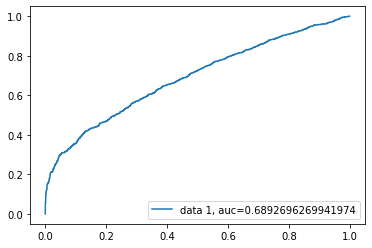

In [ ]:
# weighted AUC
fpr, tpr, _ = sklearn.metrics.roc_curve(df_test['bought'],  df_test['pred_proba'], sample_weight=df_test['sample_weight'])
auc = sklearn.metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'], sample_weight=df_test['sample_weight'])
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# weighted accuracy
sklearn.metrics.classification_report(df_test['bought'], df_test['pred'], sample_weight= df_test['sample_weight'], output_dict=True)

{'0': {'f1-score': 0.5045292083595184,
  'precision': 0.4211186732242254,
  'recall': 0.6291428806826029,
  'support': 253.49742609207104},
 '1': {'f1-score': 0.7054964957255869,
  'precision': 0.7996382722486786,
  'recall': 0.6311866098317453,
  'support': 594.4306599106659},
 'accuracy': 0.6305756145274399,
 'macro avg': {'f1-score': 0.6050128520425526,
  'precision': 0.610378472736452,
  'recall': 0.6301647452571741,
  'support': 847.9280860027369},
 'weighted avg': {'f1-score': 0.6454151151026558,
  'precision': 0.6864756754883302,
  'recall': 0.6305756145274393,
  'support': 847.9280860027369}}

## Grid search

In [ ]:
def get_model(param):
    discount = Input(shape=(1,), name='discount')
    price = Input(shape=(1,), name='price')
    diffs = Input(shape=(1,), name='diffs')

    product = Input(shape = (1,), name='product')
    product_emb = Embedding(name = 'product_emb', input_dim = item_len, output_dim = 100)(product)
    product_emb = Flatten()(product_emb)

    user = Input(shape = (1,), name='user')
    user_emb = Embedding(name = 'user_emb',  input_dim = user_len,  output_dim = 100)(user)
    user_emb = Flatten()(user_emb)

    week = Input(shape = (1,), name='week')
    week_emb = Embedding(name = 'week_emb', input_dim = week_len, output_dim = 100)(week)
    week_emb = Flatten()(week_emb)

    subcategory = Input(shape=(1,), name='subcategory')
    subcategory_emb = Embedding(name = 'subcategory_emb', input_dim = subcat_len, output_dim = 100)(subcategory)
    subcategory_emb = Flatten()(subcategory_emb)


    purchase_history = Input(shape=(1,30), name='purchase_history')
    lstm_out = Bidirectional(LSTM(units= param['lstm_units'], input_dim=features, #return_sequences=True
                                ))(purchase_history)                         

    x = concatenate([discount, price, diffs, product_emb, user_emb, week_emb, subcategory_emb, lstm_out])

    x = Dense(units=param['dense_units'], activation='relu')(x)
    x = Dense(units=1, activation='sigmoid')(x)
    model = Model(inputs=[discount, price, diffs, product, user, week, subcategory, purchase_history], outputs=[x])
    model.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(learning_rate=param['lr']),
                      metrics=['AUC', keras.metrics.BinaryAccuracy()])     
    
    return model

In [ ]:
param_grid = {
    'dense_units': [256], 
    'lstm_units': [64, 128, 256],
    'lr': [1e-3, 1e-4, 1e-5], 
    'epochs': 200, 
    'batch_size': [512, 1024, 2048]
}
early = EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)
kgs = KerasRandomSearch(get_model, param_grid, monitor='val_binary_accuracy', greater_is_better=True, n_iter=27)
kgs.search([df_train['discount'],df_train['price'], df_train['diffs'], 
                     df_train['product_id'], df_train['user_id'],
                     df_train['week'],  df_train['subcategory_name'],
                     x_train],
                    df_train['bought'],

                    validation_data= ([df_test['discount'],df_test['price'], df_test['diffs'], 
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'],  df_test['subcategory_name'],
                     x_test],
                    df_test['bought']), callbacks=[early])


27 trials detected for ('dense_units', 'lstm_units', 'lr', 'epochs', 'batch_size')

***** (1/27) *****
Search({'dense_units': 256, 'lstm_units': 64, 'lr': 0.0001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.77142 at epoch 11

***** (2/27) *****
Search({'dense_units': 256, 'lstm_units': 128, 'lr': 1e-05, 'epochs': 200, 'batch_size': 512})
SCORE: 0.76663 at epoch 39

***** (3/27) *****
Search({'dense_units': 256, 'lstm_units': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.78068 at epoch 5

***** (4/27) *****
Search({'dense_units': 256, 'lstm_units': 64, 'lr': 1e-05, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.76336 at epoch 69

***** (5/27) *****
Search({'dense_units': 256, 'lstm_units': 64, 'lr': 0.001, 'epochs': 200, 'batch_size': 2048})
SCORE: 0.77804 at epoch 4

***** (6/27) *****
Search({'dense_units': 256, 'lstm_units': 64, 'lr': 0.0001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.77344 at epoch 14

***** (7/27) *****
Search({'dense_units': 256, 'lstm_units': 256

## Recall@N

In [ ]:
df['user_id'] = df['user_id'].astype('int')
df['product_id'] = df['product_id'].astype('int')
df['week'] = df['week'].astype('int')
df['day'] = df['day'].astype('int')

In [ ]:
all_users = df[df['data_split'] == 'test']['user_id'].unique().tolist()
recall_matrix = np.zeros(shape=(len(all_users),2))
recall_matrix_weighted = np.zeros(shape=(len(all_users),2))

In [ ]:
for user_id in tqdm(all_users):
  max_date = max(df[df['user_id'] == user_id]['day'])

  df_train = df[(df['user_id'] == user_id) & (df['data_split'] == 'train')]
  df_train = df_train[['day', 'week', 'year', 'article_text', 'product_id', 'subcategory_name', 'category_name', 'weekandyear', 'price', 'discount', 'diffs', 'bought', 'data_split']]


  df_test = df[(df['user_id'] == user_id) & (df['bought'] == 1) & (df['day'] == max_date)]
  df_test = df_test[['day', 'week', 'year', 'article_text', 'product_id', 'subcategory_name', 'category_name', 'weekandyear', 'price', 'discount', 'diffs', 'bought', 'data_split', 'sample_weight']]
  bought_products = df_test['product_id'].unique()

  df_day = df[(df['day'] == max_date) & (df['bought'] == 1) & (df['user_id'] != user_id)]
  df_day = df_day.groupby(['day', 'week', 'year', 'article_text', 'product_id', 'subcategory_name', 'category_name', 'weekandyear', 'sample_weight'], as_index=False).aggregate({
      'price' : 'first',
      'discount': 'first',
      'diffs' : 'first',
  })
  df_day = df_day.loc[~df_day['product_id'].isin(bought_products)]
  df_day['bought'] = 0
  df_day['data_split'] = 'test'

  df_test = df_test.append(df_day)

  train = df_train.append(df_test)
  train['user_id'] = user_id


  train['day'] = train['day'].astype('str')

  bought_df = train[train['bought'] == 1]
  purchase_history = bought_df.groupby(['product_id', 'user_id'], as_index=False).aggregate({'day' : 'unique'})
  purchase_history.rename(columns={'day' : 'purchase_history'}, inplace=True)
  # merge with actual df
  train = pd.merge(train, purchase_history, how='left', on=['user_id', 'product_id'])

  user_history = bought_df.groupby(['user_id'], as_index=False).aggregate({'day' : 'unique'})
  user_history.rename(columns={'day' : 'user_history'}, inplace=True)
  user_history['user_history'] = user_history['user_history'].map(lambda x: np.sort(x))
  train = pd.merge(train, user_history, how='left', on=['user_id'])

  train['user_history'] = train['user_history'].map(lambda x: [int(i) for i in x])

  train['user_history'] = train['user_history'].map(lambda x: np.sort(x))

  train['day'] = train['day'].astype('int')

  def get_last_30(seq, value):
      lst = []
      for s in seq:
          if s < value:
              lst.append(s)
      return lst[-30:]

  train['last_30_purchase_days'] = train.apply(lambda x: get_last_30(x.user_history, x.day), axis=1)
  train['purchase_history'] = np.where(train['purchase_history'].isna(), "", train['purchase_history'])
  train['purchase_history'] = train['purchase_history'].map(lambda x: [int(i) for i in x])
  train['purchase_history'] = train['purchase_history'].map(lambda x: np.sort(x))

  train['purchase_history'] = train['purchase_history'].map(lambda x: [str(i) for i in x])
  train['last_30_purchase_days'] = train['last_30_purchase_days'].map(lambda x: [str(i) for i in x])
  train['30_day_purchase_history'] = train.apply(lambda x: [1 if str(i) in x.purchase_history else -1 for i in x.last_30_purchase_days], axis=1)
  padded_window_30 = pad_sequences(train['30_day_purchase_history'],30,padding='pre')
  train['30_day_purchase_history'] = padded_window_30.tolist()

  df_test = train[(train['data_split'] == 'test')]

  x_test = np.stack((df_test['30_day_purchase_history']) , axis=0 )
  x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
  df_test['week'] = df_test['week'].astype('int')

  predictions = model.predict([df_test['discount'],df_test['price'], df_test['diffs'], 
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'],  df_test['subcategory_name'],
                     x_test])
  df_test['ypred_proba'] = predictions
  df_test['sample_weight_for_only_bought'] = np.where(df_test['bought'] == 1, df_test['sample_weight'], 0)
  df_test['norm_weight'] = df_test['sample_weight_for_only_bought'] / df_test.groupby('day')['sample_weight_for_only_bought'].transform('sum')
  df_test['norm_weight'] = df_test['norm_weight'] * df_test.groupby('day')['bought'].transform('sum')

  recall_matrix[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['bought'].sum() / df_test['bought'].sum()) * 100])
  recall_matrix_weighted[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['norm_weight'].sum() / df_test['bought'].sum()) * 100])

In [ ]:
pd.DataFrame(recall_matrix)[1].mean()

38.79851471658365

In [ ]:
pd.DataFrame(recall_matrix_weighted)[1].mean()

31.836935916899648

# LSTM w/ Attention

## Model

In [ ]:
x_train = np.stack((df_train['30_day_purchase_history']) , axis=0 )
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = np.stack((df_test['30_day_purchase_history']) , axis=0 )
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
features = x_train.shape[2]

In [ ]:
#multiple input model
discount = Input(shape=(1,), name='discount')
price = Input(shape=(1,), name='price')
diffs = Input(shape=(1,), name='diffs')

product = Input(shape = (1,), name='product')
product_emb = Embedding(name = 'product_emb', input_dim = item_len, output_dim = 100,
                          #embeddings_initializer=tf.keras.initializers.Constant(pretrained_weights_products),
                          #trainable=True
                        )(product)
product_emb = Flatten()(product_emb)

user = Input(shape = (1,), name='user')
user_emb = Embedding(name = 'user_emb',  input_dim = user_len,  output_dim = 100,
                          #embeddings_initializer=tf.keras.initializers.Constant(pretrained_user_weights),
                          #trainable=True
                     )(user)
user_emb = Flatten()(user_emb)

week = Input(shape = (1,), name='week')
week_emb = Embedding(name = 'week_emb', input_dim = week_len, output_dim = 100)(week)
week_emb = Flatten()(week_emb)

subcategory = Input(shape=(1,), name='subcategory')
subcategory_emb = Embedding(name = 'subcategory_emb', input_dim = subcat_len, output_dim = 100)(subcategory)
subcategory_emb = Flatten()(subcategory_emb)


purchase_history = Input(shape=(1,30), name='purchase_history')
lstm_out = LSTM(128, input_dim=features, return_sequences=True, #use_bias=False
                             )(purchase_history)                         
lstm_out = SeqWeightedAttention()(lstm_out)


x = concatenate([
                 discount, 
                 price, 
                 diffs, 
                 product_emb, user_emb, week_emb, subcategory_emb, 
                 lstm_out
                 ])

x = Dense(units=256, activation='relu')(x)
x = Dense(units=1, activation='sigmoid')(x)
model = Model(inputs=[
                     discount, 
                     price, 
                     diffs, 
                     product, user, week, subcategory, 
                     purchase_history
                      ], outputs=[x])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
week (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
subcategory (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

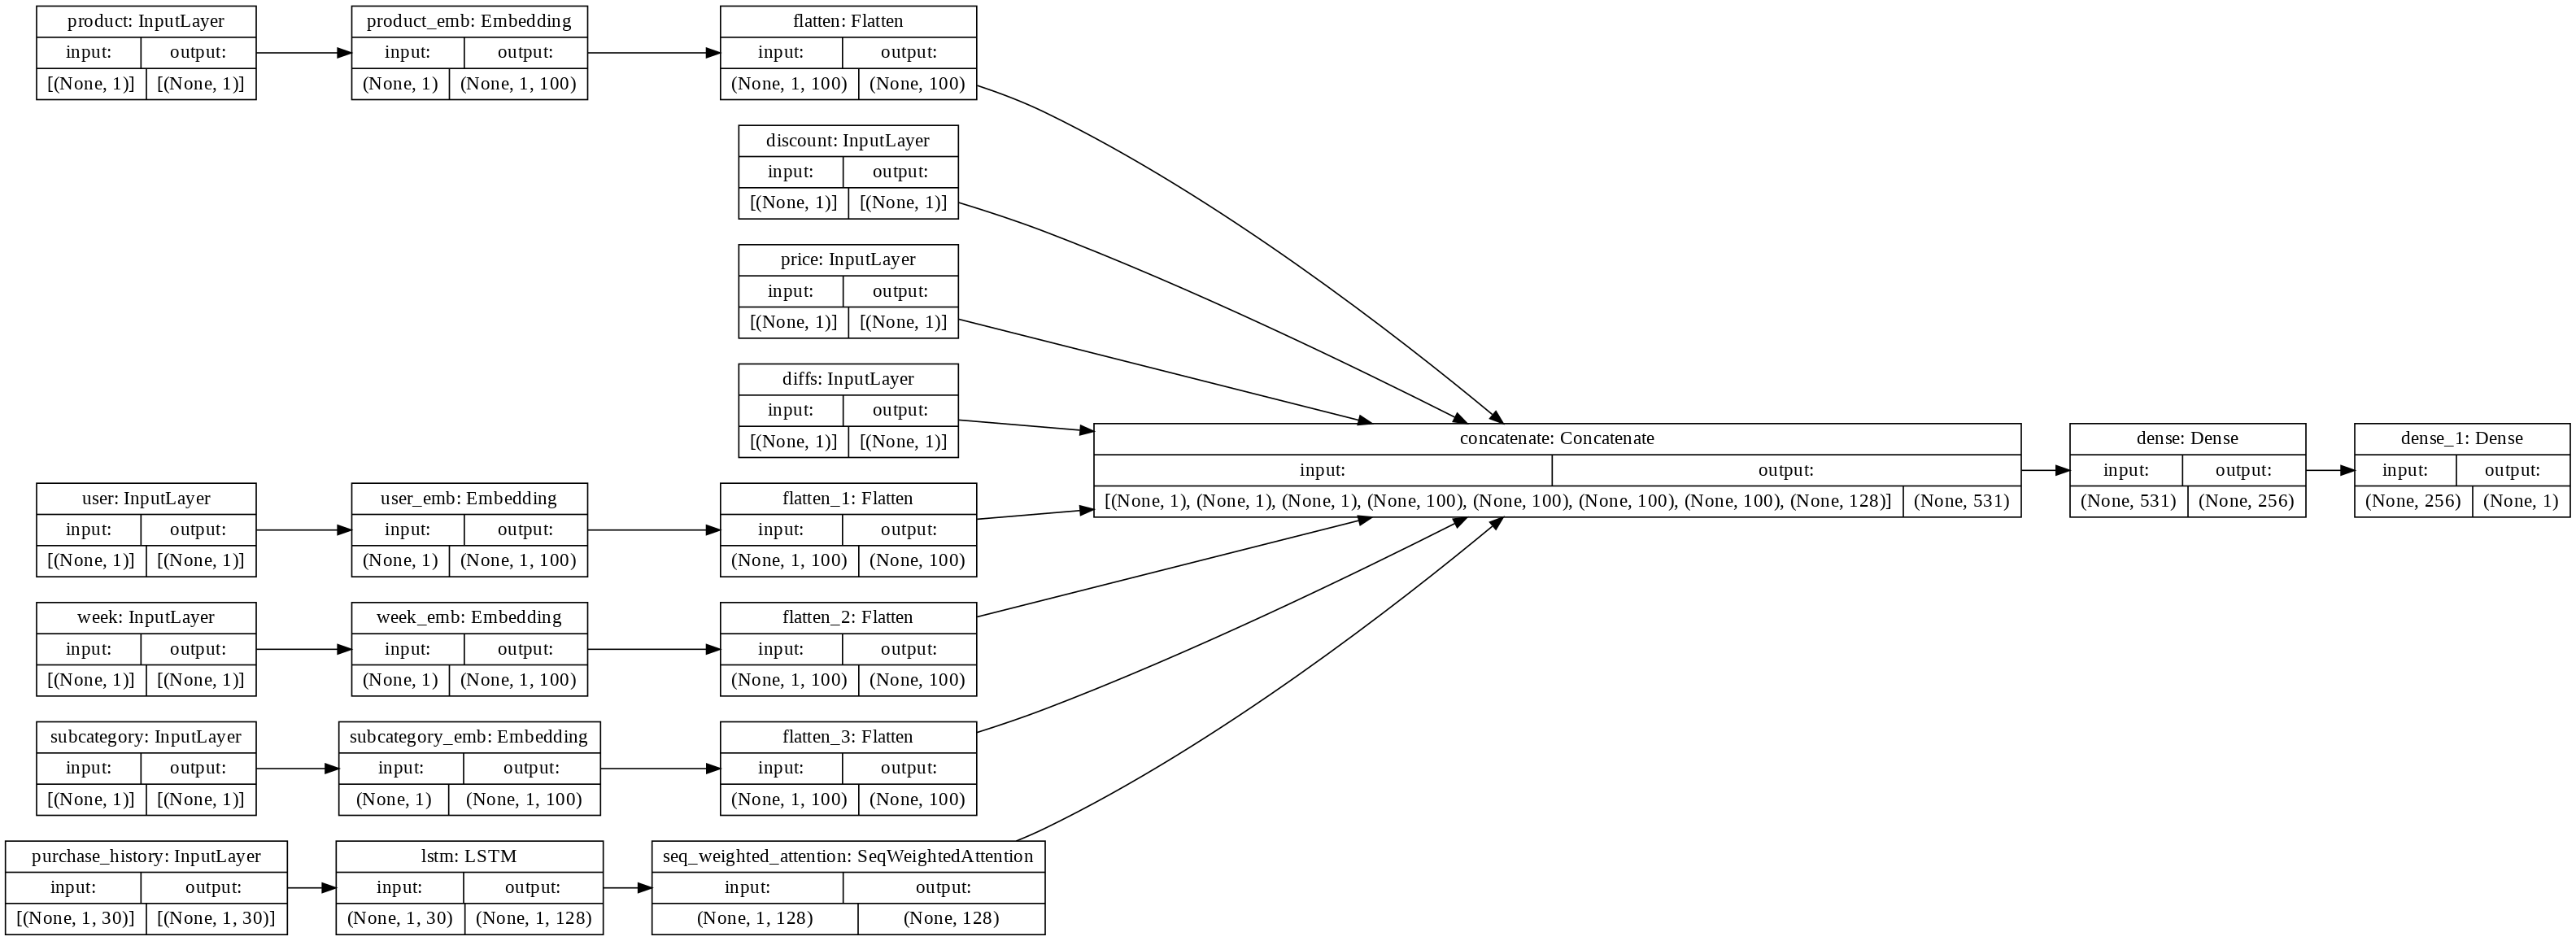

In [ ]:
tf.keras.utils.plot_model(
    model, show_shapes=True, rankdir='LR',
    show_layer_names=True, dpi=120)

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['AUC', keras.metrics.BinaryAccuracy()])

early = EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=5, restore_best_weights=True)

model.fit([
                     df_train['discount'],
                     df_train['price'], 
                     df_train['diffs'], 
                     df_train['product_id'], df_train['user_id'],
                     df_train['week'],  df_train['subcategory_name']
                     ,x_train
                     ],
                    df_train['bought'],

                    validation_data= ([
                    df_test['discount'],
                    df_test['price'], 
                    df_test['diffs'], 
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'],  df_test['subcategory_name']
                     ,x_test
                     ],
                    df_test['bought'],), 
                    batch_size=512, epochs=200, callbacks=[early]
                    )

Epoch 1/200
2352/2352 [==============================] - 54s 22ms/step - loss: 0.5154 - auc: 0.8149 - binary_accuracy: 0.7376 - val_loss: 0.5066 - val_auc: 0.8421 - val_binary_accuracy: 0.7450
Epoch 2/200
2352/2352 [==============================] - 49s 21ms/step - loss: 0.4318 - auc: 0.8793 - binary_accuracy: 0.7956 - val_loss: 0.4743 - val_auc: 0.8538 - val_binary_accuracy: 0.7728
Epoch 3/200
2352/2352 [==============================] - 49s 21ms/step - loss: 0.4094 - auc: 0.8925 - binary_accuracy: 0.8077 - val_loss: 0.4687 - val_auc: 0.8584 - val_binary_accuracy: 0.7782
Epoch 4/200
2352/2352 [==============================] - 49s 21ms/step - loss: 0.3957 - auc: 0.9001 - binary_accuracy: 0.8157 - val_loss: 0.4692 - val_auc: 0.8614 - val_binary_accuracy: 0.7841
Epoch 5/200
2352/2352 [==============================] - 49s 21ms/step - loss: 0.3830 - auc: 0.9070 - binary_accuracy: 0.8233 - val_loss: 0.4668 - val_auc: 0.8625 - val_binary_accuracy: 0.7808
Epoch 6/200
2352/2352 [============

## Evaluation

In [ ]:
predictions = model.predict([
                             df_test['discount'],
                             df_test['price'], 
                             df_test['diffs'], 
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'],  df_test['subcategory_name']
                     ,x_test
                     ])
df_test['pred_proba']  = predictions
predictions_x = np.where(predictions > 0.5, 1, 0)
df_test['pred'] = predictions_x

0.8613819594685914


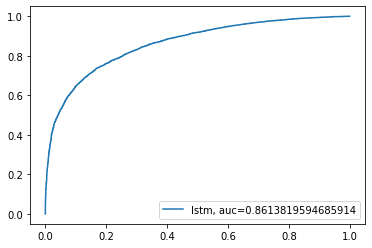

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(df_test['bought'],  df_test['pred_proba'])
auc = sklearn.metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'])
print(auc)
plt.plot(fpr,tpr,label="lstm, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
sklearn.metrics.classification_report(df_test['bought'], predictions_x, output_dict=True)

{'0': {'f1-score': 0.7939885782987677,
  'precision': 0.7591677204276354,
  'recall': 0.8321572580645161,
  'support': 7936},
 '1': {'f1-score': 0.7731815474220662,
  'precision': 0.8143036386449184,
  'recall': 0.7360131048387096,
  'support': 7936},
 'accuracy': 0.7840851814516129,
 'macro avg': {'f1-score': 0.783585062860417,
  'precision': 0.7867356795362769,
  'recall': 0.7840851814516129,
  'support': 15872},
 'weighted avg': {'f1-score': 0.7835850628604171,
  'precision': 0.786735679536277,
  'recall': 0.7840851814516129,
  'support': 15872}}

0.6417747679008183


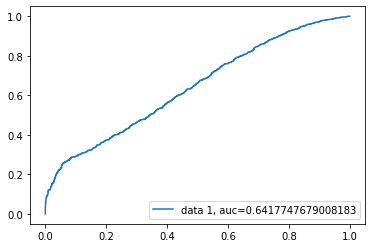

In [ ]:
# weighted AUC
fpr, tpr, _ = sklearn.metrics.roc_curve(df_test['bought'],  df_test['pred_proba'], sample_weight=df_test['sample_weight'])
auc = sklearn.metrics.roc_auc_score(df_test['bought'], df_test['pred_proba'], sample_weight=df_test['sample_weight'])
print(auc)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#weighted accuracy
sklearn.metrics.classification_report(df_test['bought'], df_test['pred'], sample_weight= df_test['sample_weight'], output_dict=True)

{'0': {'f1-score': 0.4553651019033156,
  'precision': 0.36782878763582194,
  'recall': 0.5975772069507356,
  'support': 233.83115163994572},
 '1': {'f1-score': 0.6510209153075289,
  'precision': 0.7681556517085093,
  'recall': 0.56488289287975,
  'support': 551.9239419021508},
 'accuracy': 0.5746123227926175,
 'macro avg': {'f1-score': 0.5531930086054222,
  'precision': 0.5679922196721656,
  'recall': 0.5812300499152427,
  'support': 785.7550935420965},
 'weighted avg': {'f1-score': 0.5927961267578045,
  'precision': 0.6490232497325373,
  'recall': 0.5746123227926178,
  'support': 785.7550935420965}}

## Recall@N

In [ ]:
df['user_id'] = df['user_id'].astype('int')
df['product_id'] = df['product_id'].astype('int')
df['week'] = df['week'].astype('int')

In [ ]:
all_users = df[df['data_split'] == 'test']['user_id'].unique().tolist()
recall_matrix = np.zeros(shape=(len(all_users),2))
recall_matrix_weighted = np.zeros(shape=(len(all_users),2))

In [ ]:
for user_id in tqdm(all_users):
  max_date = max(df[df['user_id'] == user_id]['day'])
  df_train = df[(df['user_id'] == user_id) & (df['data_split'] == 'train')]
  df_train = df_train[['day', 'week', 'year', 'article_text', 'product_id', 'subcategory_name', 'category_name', 'weekandyear', 'price', 'discount', 'diffs', 'bought', 'data_split']]


  df_test = df[(df['user_id'] == user_id) & (df['bought'] == 1) & (df['day'] == max_date)]
  df_test = df_test[['day', 'week', 'year', 'article_text', 'product_id', 'subcategory_name', 'category_name', 'weekandyear', 'price', 'discount', 'diffs', 'bought', 'data_split', 'sample_weight']]
  bought_products = df_test['product_id'].unique()

  df_day = df[(df['day'] == max_date) & (df['bought'] == 1) & (df['user_id'] != user_id)]
  df_day = df_day.groupby(['day', 'week', 'year', 'article_text', 'product_id', 'subcategory_name', 'category_name', 'weekandyear', 'sample_weight'], as_index=False).aggregate({
      'price' : 'first',
      'discount': 'first',
      'diffs' : 'first',
  })
  df_day = df_day.loc[~df_day['product_id'].isin(bought_products)]
  df_day['bought'] = 0
  df_day['data_split'] = 'test'

  df_test = df_test.append(df_day)

  train = df_train.append(df_test)
  train['user_id'] = user_id


  train['day'] = train['day'].astype('str')

  bought_df = train[train['bought'] == 1]
  purchase_history = bought_df.groupby(['product_id', 'user_id'], as_index=False).aggregate({'day' : 'unique'})
  purchase_history.rename(columns={'day' : 'purchase_history'}, inplace=True)
  # merge with actual df
  train = pd.merge(train, purchase_history, how='left', on=['user_id', 'product_id'])

  user_history = bought_df.groupby(['user_id'], as_index=False).aggregate({'day' : 'unique'})
  user_history.rename(columns={'day' : 'user_history'}, inplace=True)
  user_history['user_history'] = user_history['user_history'].map(lambda x: np.sort(x))
  train = pd.merge(train, user_history, how='left', on=['user_id'])

  train['user_history'] = train['user_history'].map(lambda x: [int(i) for i in x])

  train['user_history'] = train['user_history'].map(lambda x: np.sort(x))

  train['day'] = train['day'].astype('int')

  def get_last_30(seq, value):
      lst = []
      for s in seq:
          if s < value:
              lst.append(s)
      return lst[-30:]

  train['last_30_purchase_days'] = train.apply(lambda x: get_last_30(x.user_history, x.day), axis=1)
  train['purchase_history'] = np.where(train['purchase_history'].isna(), "", train['purchase_history'])
  train['purchase_history'] = train['purchase_history'].map(lambda x: [int(i) for i in x])
  train['purchase_history'] = train['purchase_history'].map(lambda x: np.sort(x))

  train['purchase_history'] = train['purchase_history'].map(lambda x: [str(i) for i in x])
  train['last_30_purchase_days'] = train['last_30_purchase_days'].map(lambda x: [str(i) for i in x])
  train['30_day_purchase_history'] = train.apply(lambda x: [1 if str(i) in x.purchase_history else -1 for i in x.last_30_purchase_days], axis=1)
  padded_window_30 = pad_sequences(train['30_day_purchase_history'],30,padding='pre')
  train['30_day_purchase_history'] = padded_window_30.tolist()

  df_test = train[(train['data_split'] == 'test')]

  x_test = np.stack((df_test['30_day_purchase_history']) , axis=0 )
  x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
  df_test['week'] = df_test['week'].astype('int')

  predictions = model.predict([df_test['discount'],df_test['price'], df_test['diffs'], 
                     df_test['product_id'], df_test['user_id'],
                     df_test['week'],  df_test['subcategory_name'],
                     x_test])
  df_test['ypred_proba'] = predictions
  df_test['sample_weight_for_only_bought'] = np.where(df_test['bought'] == 1, df_test['sample_weight'], 0)
  df_test['norm_weight'] = df_test['sample_weight_for_only_bought'] / df_test.groupby('day')['sample_weight_for_only_bought'].transform('sum')
  df_test['norm_weight'] = df_test['norm_weight'] * df_test.groupby('day')['bought'].transform('sum')

  recall_matrix[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['bought'].sum() / df_test['bought'].sum()) * 100])
  recall_matrix_weighted[user_id] = np.asarray([user_id, (df_test.sort_values(by='ypred_proba', ascending=False).head(35)['norm_weight'].sum() / df_test['bought'].sum()) * 100])

In [ ]:
pd.DataFrame(recall_matrix)[1].mean()

45.09407386103312

In [ ]:
pd.DataFrame(recall_matrix_weighted)[1].mean()

34.81736915357063